# Evaluations for maximum likelihood

## 1. Actual data likelihood
## 2. Amari distance

In [1]:
import jax
from jax import numpy as jnp
import numpy as np
import distrax
import haiku as hk
from residual import TriangularResidual, spectral_norm_init, spectral_normalization, masks_triangular_weights, make_weights_triangular, LipSwish

from jax.experimental.optimizers import adam

In [2]:
key = jax.random.PRNGKey(1)

## Generate data

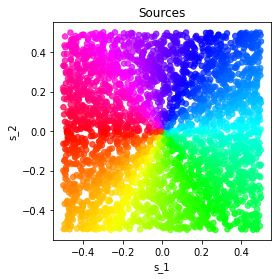

In [3]:
# N:=Number of samples
N = 3000
# D:=Number of dimensions
D = 2

# Generate the samples
S = jax.random.uniform(key, shape=(N, D), minval=0.0, maxval=1.0)

S -= 0.5


from plotting import cart2pol, scatterplot_variables

_, colors = cart2pol( S[:,0], S[:,1])

# Plot the sources
scatterplot_variables(S, 'Sources', colors=colors, savefig=False)

In [4]:
# from mixing_functions import build_conformal_map
# nonlinearity = lambda x : jnp.exp(1.3*x)
# mixing, mixing_gridplot = build_conformal_map(nonlinearity)

from mixing_functions import build_moebius_transform

# Generate a random orthogonal matrix
from scipy.stats import ortho_group # Requires version 0.18 of scipy

# A = ortho_group.rvs(dim=D)
A =np.array([[-0.98601346, -0.16666568],
       [-0.16666568,  0.98601346]])

# Scalar
alpha = 3.5
# Two vectors with data dimensionality
a = np.array([2.1, 3.5]) #2.0 * np.ones(D) # a vector in \RR^D
b = 3.0 * np.ones(D) # a vector in \RR^D

from jax import vmap
mixing_moebius, unmixing_moebius = build_moebius_transform(alpha, A, a, b, epsilon=2)
mixing_batched = vmap(mixing_moebius)

from jax import vmap

mixing_batched = vmap(mixing_moebius)

In [5]:
A

array([[-0.98601346, -0.16666568],
       [-0.16666568,  0.98601346]])

In [6]:
# X = S @ A

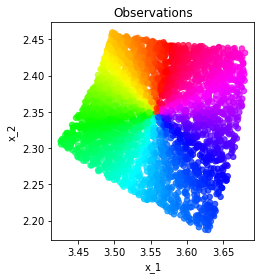

In [7]:
X = mixing_batched(S)
# X -= jnp.mean(X, axis=0)
# X /= jnp.std(X, axis=0)

scatterplot_variables(X, 'Observations', colors=colors, savefig=False)#True, fname="observations_flow")

In [8]:
unmixing_batched = vmap(unmixing_moebius)

In [9]:
Y = unmixing_batched(X)

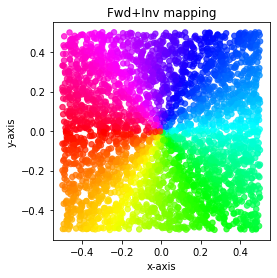

In [10]:
scatterplot_variables(Y, 'Fwd+Inv mapping', colors=colors, savefig=False)#True, fname="observations_flow")

## 1. Compute the true data likelihood

In [11]:
from metrics import observed_data_likelihood

In [12]:
# observed_data_likelihood(X[0], unmixing_moebius)

In [13]:
observed_likelihood_batched = vmap(lambda y: observed_data_likelihood(y, unmixing_moebius))

In [14]:
obs_likel = observed_likelihood_batched(X)

In [15]:
jnp.mean(obs_likel)

DeviceArray(3.1202748, dtype=float32)

## Set up model

In [16]:
n_layers = 10 #32
hidden_units = [40, 40] #[128, 128]

# I would substitute the Normal with a Logistic distribution

def log_prob(x):
    base_dist = distrax.Independent(distrax.Logistic(loc=jnp.zeros(2), scale=jnp.ones(2)),
                                                    reinterpreted_batch_ndims=1)
    flows = distrax.Chain([TriangularResidual(hidden_units + [2], name='residual_' + str(i))
                           for i in range(n_layers)])
    model = distrax.Transformed(base_dist, flows)
    return model.log_prob(x)

In [17]:
# Init model
logp = hk.transform(log_prob)
params = logp.init(key, jnp.array(np.random.randn(5, 2)))

In [18]:
# In ML + C_IMA, we don't want triangular Jacobian! I comment out the below

# # Make triangular
# masks = masks_triangular_weights([h // 2 for h in hidden_units])
# params = make_weights_triangular(params, masks)

In [19]:
# This is one part of the loss!
# Copied over from the triangular_residual_flow_test notebook

def inv_map_fn(x):
    flows = distrax.Chain([TriangularResidual(hidden_units + [2], name='residual_' + str(i))
                           for i in range(n_layers)])
    return flows.inverse(x)

inv_map = hk.transform(inv_map_fn)

def cima(x, params):
    jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params, None, y)))
    J = jac_fn(x)
    detJ = J[:, 0, 0] * J[:, 1, 1] - J[:, 0, 1] * J[:, 1, 0]
    out = jnp.sum(jnp.log(jnp.linalg.norm(J, axis=2)), axis=1) - jnp.log(jnp.abs(detJ))
    return out

In [20]:
# Apply spectral normalization

uv = spectral_norm_init(params, key)
params, uv = spectral_normalization(params, uv)

In [21]:
# Define a Lagrange multiplier to be multiplied before the c_ima contrast
lag_mult = 0.0

def loss(params, x):
    ll = logp.apply(params, None, x)
    c_ima = cima(x, params)
    return -jnp.mean(ll) + lag_mult * jnp.mean(c_ima)

Model training

In [22]:
opt_init, opt_update, get_params = adam(step_size=1e-3)

@jax.jit
def step(it, opt_state, uv, x):
    params = get_params(opt_state)
#     params = make_weights_triangular(params, masks) # makes Jacobian triangular
    params, uv = spectral_normalization(params, uv)
    params_flat = jax.tree_util.tree_flatten(params)[0]
    for ind in range(len(params_flat)):
        opt_state.packed_state[ind][0] = params_flat[ind]
    value, grads = jax.value_and_grad(loss, 0)(params, x)
    opt_out = opt_update(it, grads, opt_state)
    return value, opt_out, uv

In [23]:
iters, batch_size = 50000, 256

opt_state = opt_init(params)

loss_hist = np.array([])

In [24]:
for i in range(iters):
    x = X[np.random.choice(X.shape[0], batch_size)]
    value, opt_state, uv = step(i, opt_state, uv, x)
    loss_hist = np.append(loss_hist, value.item())
    if i%2000==0:
        print("iter=", i, "; loss=", value.item())

iter= 0 ; loss= 6.142869472503662
iter= 2000 ; loss= -2.722351551055908
iter= 4000 ; loss= -2.657118082046509
iter= 6000 ; loss= -2.7634758949279785
iter= 8000 ; loss= -2.828986644744873
iter= 10000 ; loss= -2.8465752601623535
iter= 12000 ; loss= -2.7115395069122314
iter= 14000 ; loss= -2.839099884033203
iter= 16000 ; loss= -2.782435417175293
iter= 18000 ; loss= -2.787004232406616
iter= 20000 ; loss= -2.7794578075408936
iter= 22000 ; loss= -2.847278356552124
iter= 24000 ; loss= -2.7959961891174316
iter= 26000 ; loss= -2.8165719509124756
iter= 28000 ; loss= -2.7363903522491455
iter= 30000 ; loss= -2.8016154766082764
iter= 32000 ; loss= -2.8032360076904297
iter= 34000 ; loss= -2.9298386573791504
iter= 36000 ; loss= -2.9746148586273193
iter= 38000 ; loss= -2.981156826019287
iter= 40000 ; loss= -2.8847501277923584
iter= 42000 ; loss= -2.9302327632904053
iter= 44000 ; loss= -2.9277853965759277
iter= 46000 ; loss= -2.9500439167022705
iter= 48000 ; loss= -2.8502588272094727


In [25]:
params_final = get_params(opt_state)
# params_final = make_weights_triangular(params_final, masks)
params_final, _ = spectral_normalization(params_final, uv)

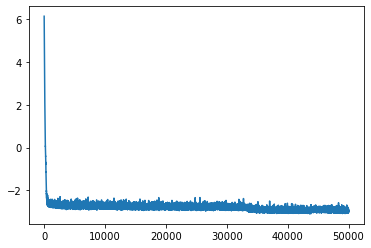

In [26]:
from matplotlib import pyplot as plt

plt.plot(loss_hist)

In [27]:
def inv_map_fn(x):
    flows = distrax.Chain([TriangularResidual(hidden_units + [2], name='residual_' + str(i))
                           for i in range(n_layers)])
    return flows.inverse(x)
inv_map = hk.transform(inv_map_fn)

In [28]:
S_rec = inv_map.apply(params_final, None, X)

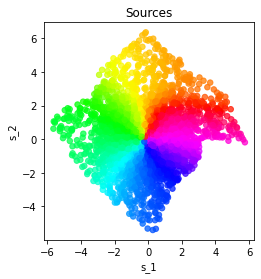

In [29]:
scatterplot_variables(S_rec, 'Sources', colors=colors, savefig=False)

In [30]:
from jax.scipy.stats import logistic

In [31]:
S_unif = logistic.cdf(S_rec) # use the Logistic cdf here!

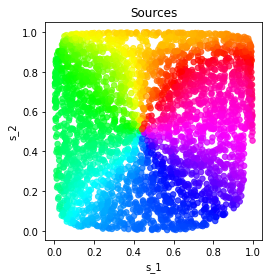

In [32]:
scatterplot_variables(S_unif, 'Sources', colors=colors, savefig=False)

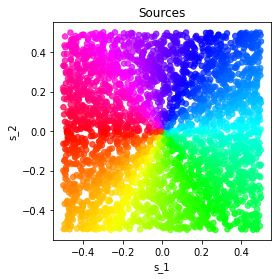

In [33]:
scatterplot_variables(S, 'Sources', colors=colors, savefig=False)

## Compute CIMA

In [34]:
def cima(x):
    jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params_final, None, y)))
    J = jac_fn(x)
    detJ = J[:, 0, 0] * J[:, 1, 1] - J[:, 0, 1] * J[:, 1, 0]
    out = jnp.sum(jnp.log(jnp.linalg.norm(J, axis=2)), axis=1) - jnp.log(jnp.abs(detJ))
    return out

In [35]:
c = cima(X)

In [36]:
jnp.mean(c)

DeviceArray(0.17196961, dtype=float32)

In [37]:
# Check that the Jacobian is **not** triangular
jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params_final, None, y)))
J = jac_fn(X)
# J.shape
mean_J = np.mean(J, axis=0)
# mean_J.shape
print(mean_J)

[[ 34.165714  24.907063]
 [-16.03263   30.191536]]


In [38]:
# for i in range(2):
#     for j in range(2):
#         plt.plot(J[i,j])
#         plt.title(str(i)+","+str(j))
#         plt.show()

In [39]:
# Use the Amari distance for evaluation

## Amari distance evaluation

Rather than the average of the Amari distances between the products of the Jacobians, we should take the Amari distance of the average of the products of the Jacobians.
Otherwise it is hard to account for the fact that the Permutation matrix might be different at different locations

In [40]:
from metrics import jacobian_amari_distance

In [41]:
# Sample P a permutation matrix
Perm = np.array([[0,1],[1,0]])# a permutation matrix

def composed_function(x):
    y = unmixing_moebius(x)
    y = y @ Perm
    z = jnp.tanh(y)
    return z

In [42]:
jac_r_unmix = jax.jacfwd(lambda y: inv_map.apply(params_final, None, y))
# jac_r_unmix = jax.jacfwd(unmixing_moebius)
# jac_r_unmix = jax.jacfwd(composed_function)
jac_t_mix = jax.jacfwd(mixing_moebius)

In [43]:
jad = jacobian_amari_distance(X, jac_r_unmix, jac_t_mix, unmixing_batched)

In [44]:
print(jad)

0.7539934


In [45]:
# To do: Visualize the distortion from original sources to reconstructed ones?
# Maybe with a gridplot?